U-net architecture  is designed for semantic segmentation

In [213]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from matplotlib import style
from collections import OrderedDict
import numpy as np
import nibabel as nib
from torch.utils.data import DataLoader , TensorDataset, SubsetRandomSampler

In [214]:
MODEL_NAME = f"model-{(time.asctime())}"  # gives a dynamic model name, to just help with things getting messy over
# time.

#IMG_SIZE = None
EPOCHS = 100
VAL_PCT = 0.4
LR = 0.001
PT = 'D:/projects/Neural_Networks/coursera_v2/coursera/model/model.pt'
#PATH_TO_DATA = None
BATCH_SIZE = 8

In [14]:
img = img/ 255.0

In [4]:
pathImgs, pathMasks = 'D:/projects/Neural_Networks/research/datasets/covid19/tr_im.nii/tr_im.nii', 'D:/projects/Neural_Networks/research/datasets/covid19/tr_mask.nii/tr_mask.nii' #enter the filepath of CT images and masks   

In [5]:
imgRaw, maskRaw = nib.load(pathImgs), nib.load(pathMasks)

In [32]:
img, mask = np.asanyarray(imgRaw.dataobj), np.asanyarray(maskRaw.dataobj) #converting dataset to numpy ndarrays
print('Dataset loaded')

Dataset loaded


In [128]:
img = cv2.resize(img, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)

mask = cv2.resize(mask, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)

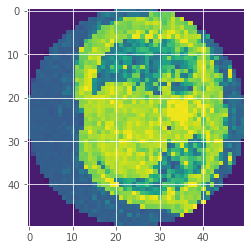

In [129]:
plt.imshow(res[:,:,0])

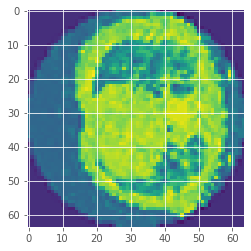

In [130]:
plt.imshow(img[:,:,0])

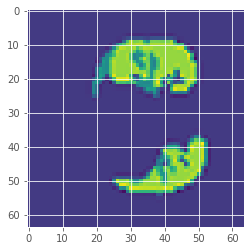

In [131]:
plt.imshow(mask[:,:,0])

In [132]:
data = []
data.append([np.array(img), np.array(mask)])

np.random.shuffle(data)
np.save("D:\\projects\\Neural_Networks\\research\\datasets\\covid19\\data.npy",data)

#img, mask = img.reshape(512,512,100,-1), mask.reshape(512,512,100,-1) #adding channel dimension
#img, mask = np.transpose(img,(2,0,1,3)), np.transpose(mask,(2,0,1,3)) #reordering arrays


In [133]:

data = np.load("D:\\projects\\Neural_Networks\\research\\datasets\\covid19\\data.npy", allow_pickle=True)


X = torch.Tensor([i[0] for i in data]) #.view(512,512,100,-1) #images
y = torch.Tensor([i[1] for i in data]) #.view(512,512,100,-1)#images

X = X/ 255.0

In [145]:
print(X.shape, y.shape)

torch.Size([100, 1, 64, 64]) torch.Size([100, 1, 64, 64])


In [144]:
X, y = torch.transpose(X, 1, 3), torch.transpose(y,1, 3) #reordering arrays

In [146]:
val_size = int(len(X) * VAL_PCT)
print(val_size)
print(len(X))
#creating data and train sets.

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

n = len(X) - val_size # iteration number
print(n)

40
100
60


In [147]:
t_dataset = TensorDataset(train_X , train_y)
train = DataLoader(t_dataset , batch_size = BATCH_SIZE, shuffle=True)

v_dataset = TensorDataset(test_X, test_y)
test = DataLoader(v_dataset, batch_size = BATCH_SIZE)


In [148]:

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on " + str(device) + ".")
else:
    device = torch.device("cpu")
    print("running on" + str(device) + ".")
# torch.cuda.device_count()


running on cuda:0.


In [200]:

class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x


class input_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(input_conv, self).__init__()
        self.inp_conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        #print("input_conv_x_ent:" , x.shape)
        x = self.inp_conv(x)
        #print("input_conv_x_ext:" , x.shape)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up_conv = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        #print("up_x1_ent:" , x1.shape)
        x1 = self.up_conv(x1)
        #print("up_x1:" , x1.shape)
        #print("up_x2:" , x2.shape)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.pool = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        #print("down_x_ent:" , x.shape)
        x = self.pool(x)
        x = self.conv(x)
        #print("down_x_ext:" , x.shape)
        return x


class last_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(last_conv, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv1(x)
        return x


class Unet(nn.Module):
    def __init__(self, channels, classes):
        super(Unet, self).__init__()
        self.inp = input_conv(channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 1024)
        self.up1 = up(1024, 512)
        self.up2 = up(512, 256)
        self.up3 = up(256, 128)
        self.up4 = up(128, 64)
        self.out = last_conv(64, classes)

    def forward(self, x):
        #print("x:", x.shape)
        x1 = self.inp(x)
        #print("x1:", x1.shape)
        x2 = self.down1(x1)
        #print("x2:", x2.shape)
        x3 = self.down2(x2)
        #print("x3:", x3.shape)
        x4 = self.down3(x3)
        #print("x4:", x4.shape)
        x5 = self.down4(x4)
        #print("x5:", x5.shape)
        x = self.up1(x5, x4)
        #print("x_up1:", x.shape)
        x = self.up2(x, x3)
        #print("x_up2:", x.shape)
        x = self.up3(x, x2)
        #print("x_up3:", x.shape)
        x = self.up4(x, x1)
        #print("x_up4:", x.shape)
        x = torch.sigmoid(self.out(x))
        #print("x:", x.shape)
        return x


In [201]:
unet = Unet(1,1).to(device)

In [202]:
#parameters

optimizer = optim.RMSprop(unet.parameters(), lr = LR)
lossf = nn.MSELoss()

In [203]:
def create_acc_loss_graph(model_name):
    contents = open("model_new.log", "r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss, epoch = c.split(",")

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))

    fig = plt.figure()

    ax1 = plt.subplot2grid((2, 1), (0, 0))
    ax2 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)

    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(times, losses, label="loss")
    ax2.plot(times, val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

In [204]:
def fwd_pass(X, y, net, train_=False):
    if train_:
        net.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True) / len(matches)
    loss = lossf(outputs, y)

    if train_:
        loss.backward()
        optimizer.step()

    return acc, loss

In [205]:
def Test(size=32):
    test_dt = next(iter(test))
    X, y = test_dt[0], test_dt[1]
    val_acc, val_loss = fwd_pass(X.to(device), y.to(device), unet)
    return val_acc, val_loss

In [212]:
def Train(net):
    with open(" model_new.log", "a") as f:
        for epoch in tqdm(range(EPOCHS)):
            for i in range(0, n, BATCH_SIZE):   
                dt = next(iter(train))
                batch_X = dt[0]
                #print(batch_X.shape)
                batch_y = dt[1]
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                acc, loss = fwd_pass(batch_X, batch_y , unet, train_=True)
                
                if i % 2 == 0:
                    val_acc, val_loss = Test(size=100)
                    f.write(
                        f"{MODEL_NAME},{round(time.time(), 3)},{round(float(acc), 2)},{round(float(loss), 4)},"
                        f"{round(float(val_acc), 2)},{round(float(val_loss), 4)},{epoch}\n")
                    torch.save({
                        'dropout cnn model': MODEL_NAME,
                        'epoch': epoch,
                        'model_state_dict': net.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict()
                    }, PT)

In [210]:
style.use("ggplot")
MODEL_NAME = f"model-{time.asctime()}" 
print(MODEL_NAME)

model-Tue Jul 28 10:19:30 2020


In [211]:
Train(unet)
create_acc_loss_graph(MODEL_NAME)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.37s/it]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 7/8 [00:09<00:01,  1.42s/it]


KeyboardInterrupt: 

In [217]:

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
#        self.bn1 = nn.BatchNorm2d(num_features=32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2 = nn.Conv2d(32, 64, 5)
#        self.bn2 = nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.bn1 = nn.BatchNorm1d(num_features=512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.fc2 = nn.Linear(512, 2)
        self.dropout = nn.AlphaDropout(p=0.3)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x

        '''>>> # With Learnable Parameters
        >>> m = nn.BatchNorm2d(100)
        >>> # Without Learnable Parameters
        >>> m = nn.BatchNorm2d(100, affine=False)
        >>> input = torch.randn(20, 100, 35, 45)
        >>> output = m(input)'''

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.fc2(x)
        x = self.dropout(x)
        return F.softmax(x, dim=1)

In [221]:

model = Net().to(device)
opt = optim.Adam(model.parameters(), lr=0.001)

checkpoint = torch.load(PT)
model.load_state_dict(checkpoint['model_state_dict'])
opt.load_state_dict(checkpoint['optimizer_state_dict'])

model.train()
outputs = model(X.to(device))

In [233]:
outputs

tensor([[9.9932e-01, 6.7783e-04],
        [9.9995e-01, 4.5099e-05],
        [1.2449e-07, 1.0000e+00],
        [1.3566e-02, 9.8643e-01],
        [9.8583e-01, 1.4174e-02],
        [3.5565e-05, 9.9996e-01],
        [1.9537e-04, 9.9980e-01],
        [7.4755e-01, 2.5245e-01],
        [9.7287e-01, 2.7131e-02],
        [1.5110e-05, 9.9998e-01],
        [3.0489e-02, 9.6951e-01],
        [1.5530e-01, 8.4470e-01],
        [1.0000e+00, 7.1825e-07],
        [2.1574e-01, 7.8426e-01],
        [5.9678e-01, 4.0322e-01],
        [5.0000e-01, 5.0000e-01],
        [5.0000e-01, 5.0000e-01],
        [5.0000e-01, 5.0000e-01],
        [9.8101e-05, 9.9990e-01],
        [9.9863e-01, 1.3725e-03],
        [9.9965e-01, 3.5038e-04],
        [2.5595e-03, 9.9744e-01],
        [1.5226e-05, 9.9998e-01],
        [9.9117e-01, 8.8256e-03],
        [9.9919e-01, 8.1496e-04],
        [9.1191e-01, 8.8091e-02],
        [9.3543e-01, 6.4565e-02],
        [9.9994e-01, 6.4623e-05],
        [9.9998e-01, 1.5720e-05],
        [5.704

In [226]:
y.shape

torch.Size([100, 1, 64, 64])

In [224]:
acc_, loss_ = fwd_pass(X.to(device), y.to(device), model)

C:\Program Files\Python37\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([100, 1, 64, 64])) that is different to the input size (torch.Size([400, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (2) must match the size of tensor b (64) at non-singleton dimension 3